In [83]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rc("font", size=22)
plt.rc("axes", titlesize=22)
scaling_obj = 1
scaling_factor = 1

from pyomo.environ import (
    Param,
    Expression,
    Objective,
    Constraint,
    units as pyunits,
    Block,
    Expr_if,
    Var,
    value,
    ComponentMap,
)
from idaes.core.solvers import get_solver
from idaes.core.util import model_statistics as stats
from watertap.examples.flowsheets.RO_multiperiod_model.multiperiod_RO import (
    create_multiperiod_swro_model,
)
import watertap.examples.flowsheets.RO_with_energy_recovery.RO_with_energy_recovery as swro
from watertap.unit_models.pressure_changer import VariableEfficiency


In [84]:
df  = pd.read_csv('results.csv')
baseline_production = 2 * np.ones(len(df['time_step']))
baseline_load = 4.43 * np.ones(len(df['time_step']))

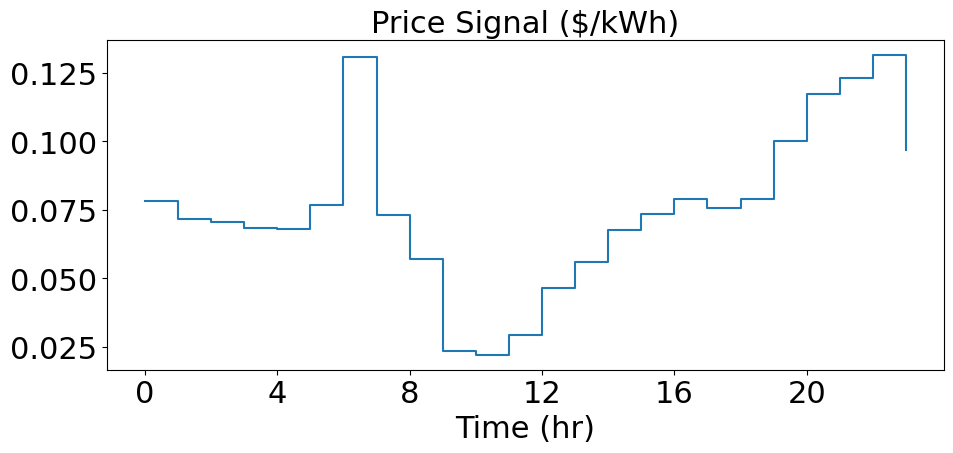

In [85]:
fig, ax = plt.subplots(figsize = (10, 5))
ax.step(df['time_step'], df['price_signal'], where = 'post')
ax.set_title('Price Signal ($/kWh)')
ax.set_xticks(np.arange(min(df.time_step), max(df.time_step)+1, 4))
ax.set_xlabel("Time (hr)")
fig.tight_layout()

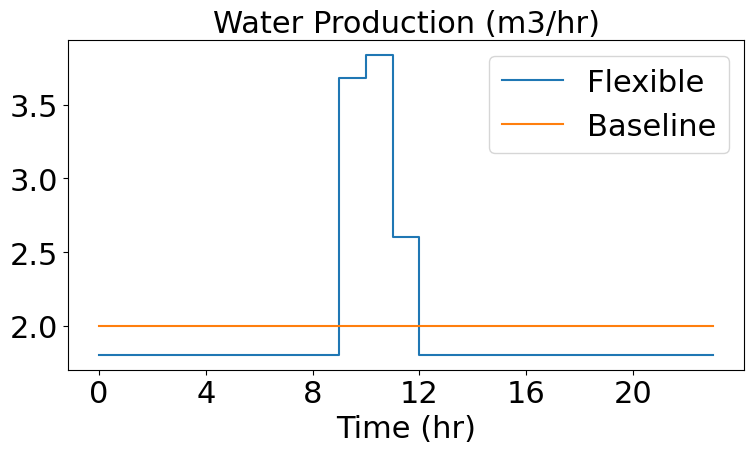

In [109]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.step(df['time_step'], df['permeate'], where = 'post', label = 'Flexible')
ax.step(df['time_step'], baseline_production, where = 'post', label = 'Baseline')
ax.set_title('Water Production (m3/hr)')
ax.set_xticks(np.arange(min(df.time_step), max(df.time_step)+1, 4))
ax.set_xlabel("Time (hr)")
ax.legend(loc='upper right')
fig.tight_layout()

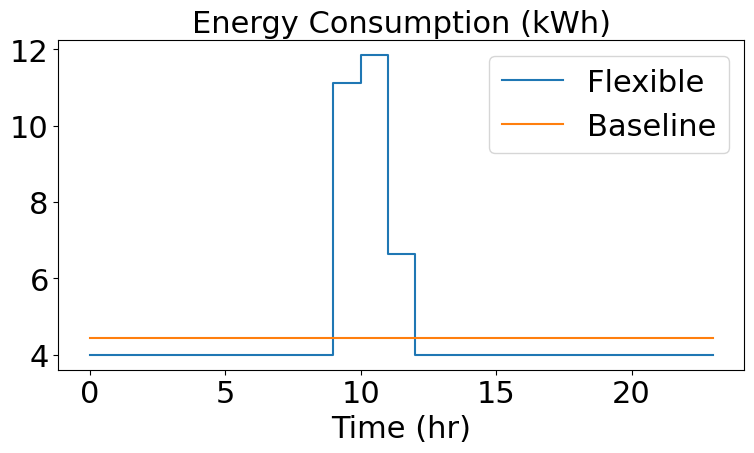

In [106]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.step(df['time_step'], df['energy_consumption'], where = 'post', label = 'Flexible')
ax.step(df['time_step'], baseline_load, where = 'post', label = 'Baseline')

charging_set = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

# plt.fill_between(df['time_step'], df['energy_consumption'], baseline_load, 
#                      where = df['energy_consumption'] >= baseline_load, 
#                      facecolor="#ADD8E6",
#                      step="pre",
#                      label = "Charging")

# plt.fill_between(df['time_step'], df['energy_consumption'], baseline_load, 
#                      where = df['energy_consumption'] <= baseline_load, 
#                      facecolor="#FFC0CB", 
#                      step="pre",
#                      label = "Discharging")

ax.legend(loc = 'upper right')
ax.set_title("Energy Consumption (kWh)")
ax.set_xlabel("Time (hr)")
fig.tight_layout()

In [115]:
rte = sum(baseline_load)/sum(df['energy_consumption'])
# print the rte rounded to2 decimal places
print('rte = {}%'.format(round(100*rte, 2)))

rte = 93.69%


In [128]:
E_charge = np.where(df['energy_consumption'] > baseline_load, df['energy_consumption'], baseline_load)
E_discharge = np.where(df['energy_consumption'] < baseline_load, df['energy_consumption'], baseline_load)

In [124]:
sum(baseline_load)

106.32000000000005

In [131]:
sum(baseline_load - E_discharge) / sum(baseline_load)

0.08611049920200949

In [133]:
sum(baseline_load - E_discharge) / 12

0.7629390229298044

In [137]:
cum_permeate = np.cumsum(df.permeate.values)
cum_baseline = np.cumsum(baseline_production)

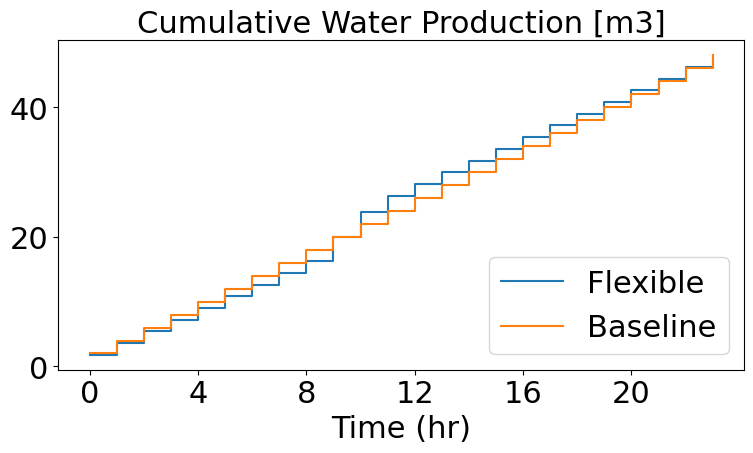

In [142]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.step(df['time_step'], cum_permeate, where = 'post', label = 'Flexible')
ax.step(df['time_step'], cum_baseline, where = 'post', label = 'Baseline')
ax.set_title("Cumulative Water Production [m3]")
ax.set_xlabel("Time (hr)")
ax.set_xticks(np.arange(min(df.time_step), max(df.time_step)+1, 4))
ax.legend(loc = 'lower right')
fig.tight_layout()

In [148]:
state_of_charge = 0.5 + (cum_permeate - cum_baseline)/cum_baseline[-1]

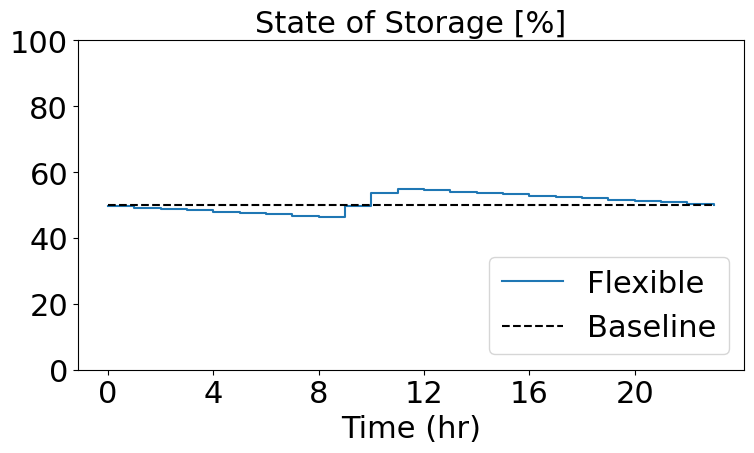

In [154]:
fig, ax = plt.subplots(figsize = (8, 5))
ax.step(df['time_step'], 100*state_of_charge, where = 'post', label = 'Flexible')
ax.plot(df['time_step'], 50*np.ones(24), '--', color = 'black', markersize = 1, label = 'Baseline')
ax.set_ylim([0,100])
ax.set_title("State of Storage [%]")
ax.set_xlabel("Time (hr)")
ax.set_xticks(np.arange(min(df.time_step), max(df.time_step)+1, 4))
ax.legend(loc = 'lower right')
fig.tight_layout()

In [221]:
r = 0.02
d = 0.2
N = 25
A = np.zeros(N)
D_exp = np.zeros(N)
for i, n in enumerate(range(25)):
    A[i] = (1+r)**(n) / (N-n)
    # D_exp[i] = (1-r)**(n) / (N-n)

    D_exp[i] = sum(np.exp(-d*np.arange(n,N))) / N
D_sl = np.ones(N)/N

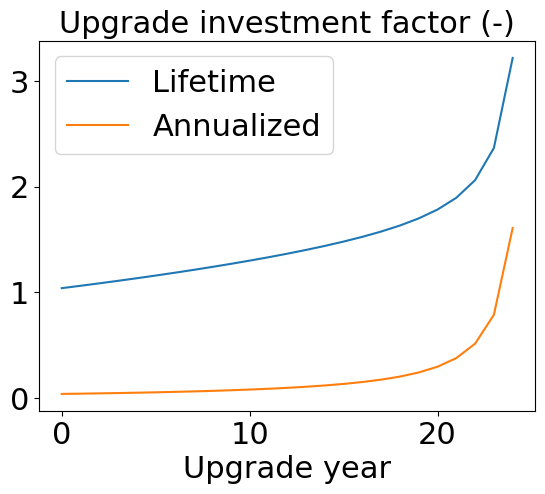

In [222]:
fig, ax = plt.subplots()
ax.plot(A*np.arange(N+1,1,-1), label = 'Lifetime')
ax.plot(A, label = 'Annualized')
ax.set_xlabel('Upgrade year')
ax.set_title('Upgrade investment factor (-)')
ax.legend()

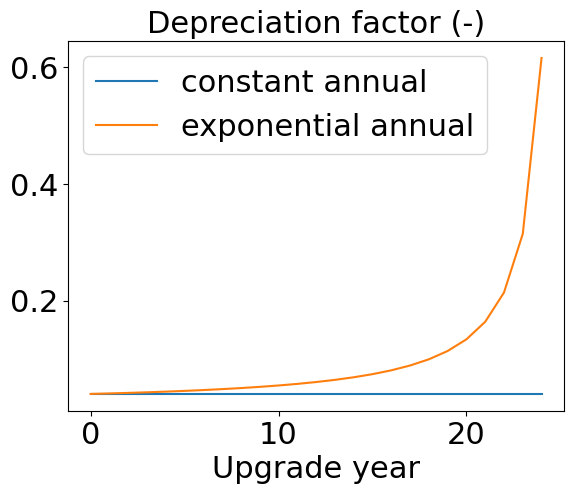

In [226]:
fig, ax = plt.subplots()
ax.plot(D_sl, label = 'constant annual')
ax.plot(D_exp, label = 'exponential annual')
ax.set_xlabel('Upgrade year')
ax.set_title('Depreciation factor (-)')
ax.legend()
